In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
from model_pyro import model

In [8]:
count_data = torch.from_numpy(np.loadtxt("txtdata.txt"))

In [9]:
kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=5000, warmup_steps=500)
posterior.run(count_data);

Sample:  74%|███████▍  | 4083/5500 [01:02, 37.07it/s, step size=1.99e-01, acc. prob=0.834]

KeyboardInterrupt: 

Sample:  74%|███████▍  | 4083/5500 [01:20, 37.07it/s, step size=1.99e-01, acc. prob=0.834]

In [5]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
lambda_1_samples = hmc_samples['lambda_1']
lambda_2_samples = hmc_samples['lambda_2']
tau_samples = (hmc_samples['tau'] * count_data.size(0) + 1).astype(int)

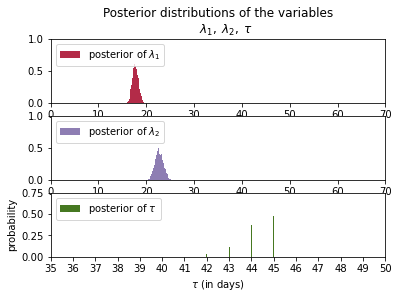

In [13]:
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 70])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([0, 70])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, 50])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

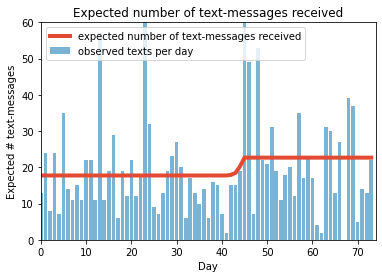

In [7]:
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");